### in case you've heard that covid deaths are inflated...
# exploring pandemic death data from the US CDC

### not interested in the details?  start [here](#US-deaths-since-2014); also working on [totaldeaths.net](https://totaldeaths.net/).

- motivation
    - https://www.businessinsider.com/yale-study-excess-deaths-nearly-twice-official-covid-19-count-2020-4?op=1
        - excess deaths exceed deaths officially attributed to covid, in US and elsewhere.
        - reliant on figures from the National Center for Health Statistics (part of the CDC).
        - at a time when traffic fatalities were in steep decline due to stay-at-home orders.
    - we exclude traffic fatalities, overdoses, suicides, etc by looking mostly at deaths from natural causes.
    - we ignore specific cause of death; we also compare general deaths with official covid deaths.
- comparisons
    - https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm
        - 13 "dashboards" but none show the excess deaths directly
        - at best they show excess deaths as part of total deaths, but not as compared with deaths attributed to covid
    - https://coronavirus.jhu.edu/
        - no 'official' vs excess deaths
- data sources
    - mmwr = Morbidity and Mortality Weekly Report
    - baseline dataset: 2014-2019
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr
            - json format:  https://data.cdc.gov/resource/3yf8-kanr.json
                - throttled unless you get an app token.
            - pandas format:  https://dev.socrata.com/foundry/data.cdc.gov/3yf8-kanr
                - no app token needed.
    - current dataset: 2020-ongoing
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
        - updated every Thursday to the week_ending_date (always a Saturday) 12 days earlier.
    - every January, the older of the two years in the current dataset is moved to the baseline dataset.
- background
    - <a id='timeliness'></a>Timeliness of Death Certificate Data  https://www.cdc.gov/nchs/data/vsrr/report001.pdf
        - the most recent data points in the current dataset are undercounts due to delays in reporting.
        - timeliness seems to have improved since this 2015 article, but the delay remains significant.
    - note that 52 weeks is just 364 days, so each year has an extra day (or two for leap years);
      thus there is a 53-mmwrweek year every 5-6 years.
    - 2014 and 2020 are the most recent 53-mmwrweek years.

In [6]:
# to start from zero, run at the commandline: 
# pip install jupyterlab numpy pandas matplotlib sodapy

# external dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

use_dark_background = 0
if use_dark_background:
    plt.style.use('dark_background')
else:
    plt.style.use('default')

In [7]:
# data loading details

# here we save the downloaded file for reuse to reduce bandwidth;
# and besides: "Requests made without an app_token will be subject to strict throttling limits."

from os import makedirs
from os.path import join, exists
from pickle import load

data_code_by_dataset = dict(
    current='muzy-jte6',
    baseline='3yf8-kanr',
)


def download_data(data_code, data_path):
    app_token = None  # no token needed for public datasets downloaded via Socrata.
    client = Socrata("data.cdc.gov", app_token)
    data = list(client.get_all(data_code))
    
    # write data to local file
    from pickle import dump
    with open(data_path, 'wb') as f:
        dump(data, f)
        
    return data

def read_local_data(data_path):
    with open(data_path, 'rb') as f:
        data = load(f)
    return data

def read_data(dataset_name):
    data_dir = 'data'
    fname = dataset_name + '.pickl'
    fpath = join(data_dir, fname)
    if not exists(data_dir):
        makedirs(data_dir)
    if exists(fpath):
        return read_local_data(fpath)
    else:
        data_code = data_code_by_dataset[dataset_name]
        return download_data(data_code, fpath)

In [46]:
# load the "current" dataset (updated weekly)
# todo n_extra_rows / nlocations in 2021 is no longer an integer--fewer locations now being reported?

data = read_data('current')

# create the current dataframe
current_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')

nlocations = len(current_df.jurisdiction_of_occurrence.unique())
n_extra_rows = len(data) - 53 * nlocations
n_extra_weeks = n_extra_rows / nlocations
if n_extra_weeks != int(n_extra_weeks):
    print('todo: check current dataset for missing locations')
print(f'''
    The current [2020-2021] dataset is {len(data)} rows,
    {n_extra_rows} rows (ie {n_extra_weeks} weeks) more than 2020's 53 weeks X 54 locations = {53 * 54} rows
    [2020 was a 53-mmwrweek year]; 
    the first row is:
    ''')
display(data[0])

# apparently the flu/pneumonia definition was adjusted between the baseline and current datasets.
# we replace the baseline and current flu/pneumonia columns with a generic name.
flu_col_generic = 'influenza_and_pneumonia_jxx_renamed'
current_df = current_df.rename(columns=dict(
    weekendingdate='week_ending_date',
    allcause='all_cause',
    naturalcause='natural_cause',
    influenza_and_pneumonia_j09_j18=flu_col_generic,
))

handle_new_year = 1   # todo
if handle_new_year:
    latest_mmwryear = current_df.mmwryear.max()
    latest_mmwryear_is_complete = 0
else:
    latest_mmwryear = 2020
    latest_mmwryear_is_complete = 1

latest_mmwrweek = current_df.query(f'mmwryear == {latest_mmwryear}').mmwrweek.max()
latest_week_ending_date = current_df.query(f'mmwryear == {latest_mmwryear} and mmwrweek == {latest_mmwrweek}').week_ending_date.unique()[0]
display(f"latest mmwryear is {latest_mmwryear}")
display(f"latest mmwrweek is {latest_mmwrweek}")
display(f"latest week_ending_date is {latest_week_ending_date}")
#display(w.jurisdiction_of_occurrence.unique())
#mmwrweek_and_week_ending_date = current_df.query(f"mmwryear == {latest_mmwryear} and jurisdiction_of_occurrence == 'United States'")
time_df = current_df.query("jurisdiction_of_occurrence == 'United States'")[['mmwryear', 'mmwrweek', 'week_ending_date']]

#mmwrweek_to_week_ending_date = dict(zip(mmwrweek_and_week_ending_date.mmwrweek, mmwrweek_and_week_ending_date.week_ending_date))
year_and_week_to_week_ending_date = dict(zip(zip(time_df.mmwryear, time_df.mmwrweek), time_df.week_ending_date))
display(current_df)

todo: check current dataset for missing locations

    The current [2020-2021] dataset is 2914 rows,
    52 rows (ie 0.9629629629629629 weeks) more than 2020's 53 weeks X 54 locations = 2862 rows
    [2020 was a 53-mmwrweek year]; 
    the first row is:
    


{'jurisdiction_of_occurrence': 'United States',
 'mmwryear': '2020',
 'mmwrweek': '1',
 'week_ending_date': '2020-01-04',
 'all_cause': '60164',
 'natural_cause': '55019',
 'septicemia_a40_a41': '846',
 'malignant_neoplasms_c00_c97': '11569',
 'diabetes_mellitus_e10_e14': '1827',
 'alzheimer_disease_g30': '2528',
 'influenza_and_pneumonia_j09_j18': '1559',
 'chronic_lower_respiratory': '3501',
 'other_diseases_of_respiratory': '1066',
 'nephritis_nephrotic_syndrome': '1095',
 'symptoms_signs_and_abnormal': '673',
 'diseases_of_heart_i00_i09': '14196',
 'cerebrovascular_diseases': '3107',
 'covid_19_u071_multiple_cause_of_death': '2',
 'covid_19_u071_underlying_cause_of_death': '2'}

'latest mmwryear is 2021'

'latest mmwrweek is 1'

'latest week_ending_date is 2021-01-09'

,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,...,flag_diab,flag_alz,flag_clrd,flag_stroke,flag_otherunk,flag_inflpn,flag_hd,flag_neopl,flag_allcause,flag_natcause
0,United States,2020,1,2020-01-04,60164.0,55019.0,846.0,11569.0,1827.0,2528.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,2020,2,2020-01-11,60721.0,55740.0,867.0,11963.0,1939.0,2564.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,2020,3,2020-01-18,59351.0,54519.0,831.0,11705.0,1818.0,2489.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,2020,4,2020-01-25,59141.0,54394.0,829.0,11879.0,1861.0,2513.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,2020,5,2020-02-01,58801.0,54007.0,811.0,11959.0,1826.0,2476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,Puerto Rico,2020,50,2020-12-12,119.0,118.0,0.0,12.0,NaN,NaN,...,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,NaN
2910,Puerto Rico,2020,51,2020-12-19,128.0,123.0,NaN,10.0,NaN,NaN,...,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,NaN
2911,Puerto Rico,2020,52,2020-12-26,61.0,61.0,0.0,NaN,NaN,NaN,...,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN
2912,Puerto Rico,2020,53,2021-01-02,12.0,12.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# combine with baseline death data 2014-2018

data = read_data('baseline')
print(f'\nbaseline has {len(data)} rows')
baseline_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')
yr_min, yr_max = baseline_df.mmwryear.min(), baseline_df.mmwryear.max()
n_yrs = yr_max - yr_min + 1
n_locs = len(baseline_df.jurisdiction_of_occurrence.unique())
print(f'compare with {n_yrs} years X 52 weeks/year * {n_locs} locations =  {n_yrs * 52 * n_locs}')
print(f'thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years\n')

# align column names with latest weekly dataset, for concatenation below
baseline_df = baseline_df.rename(columns=dict(
    weekendingdate="week_ending_date",
    allcause="all_cause",
    naturalcause="natural_cause",
    influenza_and_pneumonia_j10=flu_col_generic,
))

display(baseline_df)


baseline has 16902 rows
compare with 6 years X 52 weeks/year * 54 locations =  16848
thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years



,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,...,flag_inflpn,flag_nephr,flag_sept,flag_diab,flag_otherunk,flag_alz,flag_clrd,flag_stroke,flag_hd,flag_neopl
0,United States,2014,1,2014-01-04T00:00:00.000,54065,50189,882.0,11244.0,1654.0,1780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,2014,2,2014-01-11T00:00:00.000,56353,52450,905.0,11504.0,1735.0,1917.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,2014,3,2014-01-18T00:00:00.000,54769,51043,919.0,11496.0,1660.0,1914.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,2014,4,2014-01-25T00:00:00.000,54223,50560,845.0,11629.0,1602.0,1862.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,2014,5,2014-02-01T00:00:00.000,54074,50402,890.0,11584.0,1586.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16897,Puerto Rico,2019,48,2019-11-30T00:00:00.000,619,568,NaN,113.0,62.0,53.0,...,NaN,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN
16898,Puerto Rico,2019,49,2019-12-07T00:00:00.000,555,530,15.0,109.0,62.0,46.0,...,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16899,Puerto Rico,2019,50,2019-12-14T00:00:00.000,526,492,NaN,91.0,56.0,39.0,...,NaN,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN
16900,Puerto Rico,2019,51,2019-12-21T00:00:00.000,577,533,17.0,92.0,59.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
all_data = pd.concat([baseline_df, current_df])
loc = 'United States'
loc_data_raw = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
print(f'\ndata from 2014 thru the present totals {len(loc_data_raw)} rows,\nwhereas 7 years X 52 weeks per year = {7 * 52} weeks'
      + ' (2014 and 2020 were 53-mmwrweek years)\n')


data from 2014 thru the present totals 367 rows,
whereas 7 years X 52 weeks per year = 364 weeks (2014 and 2020 were 53-mmwrweek years)



In [12]:
def select_col(df, col):
    return pd.DataFrame({
        yr: pd.Series(
            df.query(f"mmwryear == {yr}")[col].values,
            index=df.query(f"mmwryear == {yr}").mmwrweek
        )
        for yr in range(2014, latest_mmwryear+1)
    })
all_cod_by_yr = select_col(loc_data_raw, 'all_cause')
nat_cod_by_yr = select_col(loc_data_raw, 'natural_cause')
print(f'\n{len(nat_cod_by_yr)} rows (because 2014 and 2020 were 53-mmwrweek years)\n')
#display('years included: ' + ' '.join(str(yr) for yr in nat_cod_by_yr.columns))
#display(nat_cod_by_yr)


53 rows (because 2014 and 2020 were 53-mmwrweek years)



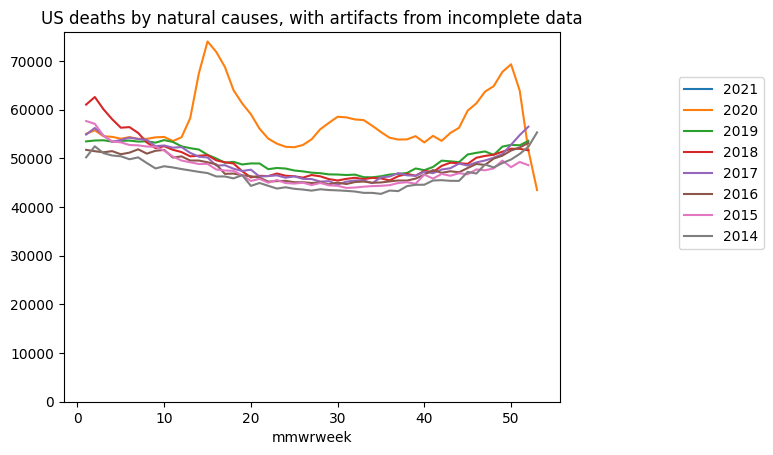

In [13]:
# plot data by year

def plot_df(df, title=None, caption=None, order=None, xylegend=None):
    
    if not xylegend:
        xylegend = (1.15, 0.8)
        
    fig = plt.figure()
    
    if title:
        plt.title(title)
        
    ax = fig.gca()
        # gca stands for 'get current axes'
    if order == 'by_sum':
        columns = [col for summ, col in reversed(sorted((df[col].sum(), col) for col in df.columns))]
    else:
        columns = order(df.columns) if order else df.columns
    # reverse columns so that legend better corresponds to location of data [2020 is uppermost]
    for yr in columns:
        df[yr].plot(kind='line',x='mmwrweek', y='natural_cause', ax=ax)
    
    # set y-axis to start at zero
    ax.set_ylim(bottom=0)
    fig.legend(bbox_to_anchor=xylegend)  #loc='lower right')
    #print(fig.legend.__doc__)
    if caption:
        fig.text(.1, -.15, caption)  #, ha='center')
    
    plt.show()

plot_df(nat_cod_by_yr, 'US deaths by natural causes, with artifacts from incomplete data', order=reversed, xylegend=(1.23,0.8))

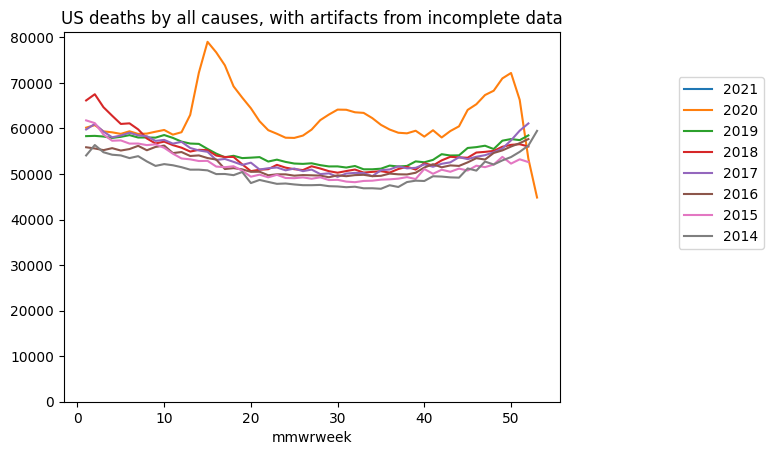

In [14]:
plot_df(all_cod_by_yr, 'US deaths by all causes, with artifacts from incomplete data', order=reversed, xylegend=(1.23,0.8))

In [15]:
# useful code to avoid using the most incomplete recent data points

from itertools import takewhile

# data from a forthcoming notebook, computed from multiple "current" weekly datasets
undercount_from_latest = [1.6488, 0.3082, 0.1064, 0.0564, 0.0365, 0.0248, 0.0163, 0.0136, 0.0131, 0.0136]

def n_weeks_to_ignore_for_max_undercount(max_undercount):
    return len(list(takewhile((lambda x: x > max_undercount), undercount_from_latest)))

def skip_most_recent(df, nweeks):
    '''
    called by trim_df_by_year, assumes cols are years 
      eg last col is just two wks cuz new year so nweeks=3 will go to previous col.
    todo but this is also called by trim_df where it should not go to previous col;
      tho will never return a buggy result in practice.
    '''
    weeks_skipped = 0
    for yr in reversed(df.columns):
        for week in reversed(df.index.values):
            val = df.loc[week, yr]
            #print(val,type(val))
            if val is None or np.isnan(val):
                continue
            if weeks_skipped < nweeks:
                df.loc[week, yr] = None
                weeks_skipped += 1
            else:
                return yr, week
            
def trim_df(df, max_undercount, columns=None):
    if not columns:
        columns = df.columns
    n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
    last_mmwrweek_to_keep = latest_mmwrweek - n_most_recent_points_to_remove
    last_year, last_week = skip_most_recent(df, n_most_recent_points_to_remove)
    df.loc[df.index > last_week, columns] = None
    return last_week, n_most_recent_points_to_remove

def trim_df_by_year(df, max_undercount):
    n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
    last_year, last_week = skip_most_recent(df, n_most_recent_points_to_remove)
    return df.loc[:, :last_year], last_year, last_week, n_most_recent_points_to_remove

def scrub_df(df, max_undercount):
    # scrub the data in two steps:

    # apparently this was corrected; no longer need to remove first point in 2014.
    # 1. remove first point in 2014 because it represents only wed-sat of that week [2014 started on a wednesday]
    # df[2014][1] = None

    # 2. remove the last few points of the current year because reporting is not yet complete.
    df, last_year, last_mmwrweek_kept, n_most_recent_points_removed = trim_df_by_year(df, max_undercount)

    return df, last_year, last_mmwrweek_kept, n_most_recent_points_removed

#display(nat_cod_by_yr)
max_undercount = 0.05   # go back far enough to avoid undercounting by more than this much.
all_cod_by_yr, last_year, last_mmwrweek_kept, n_most_recent_points_removed = scrub_df(all_cod_by_yr, max_undercount)

# US deaths since 2014

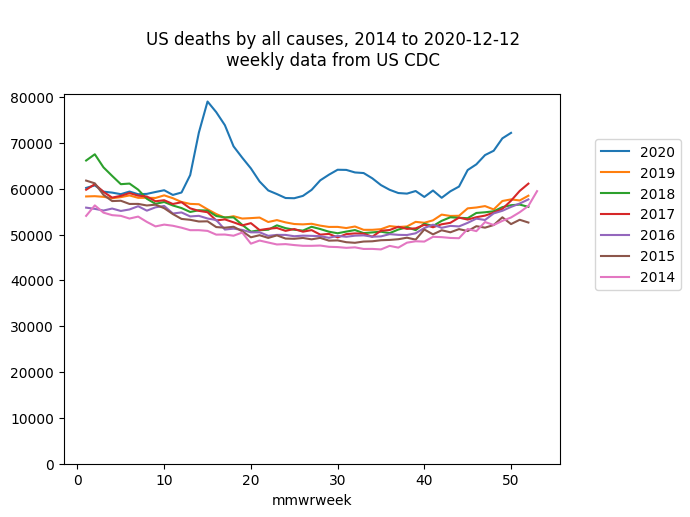

In [16]:
# plot the scrubbed data

latest_week_ending_date_displayed = year_and_week_to_week_ending_date[(last_year, last_mmwrweek_kept)]
end_date = latest_mmwryear if latest_mmwryear_is_complete else latest_week_ending_date_displayed

plot_df(
    all_cod_by_yr,
    f'''
        US deaths by all causes, 2014 to {end_date}
        weekly data from US CDC
    ''',
    order=reversed, 
    xylegend=(1.1,0.8)
)

But how many deaths might be due to covid, rather than say suicide or overdose due to depression?  Let's look at deaths from natural causes.

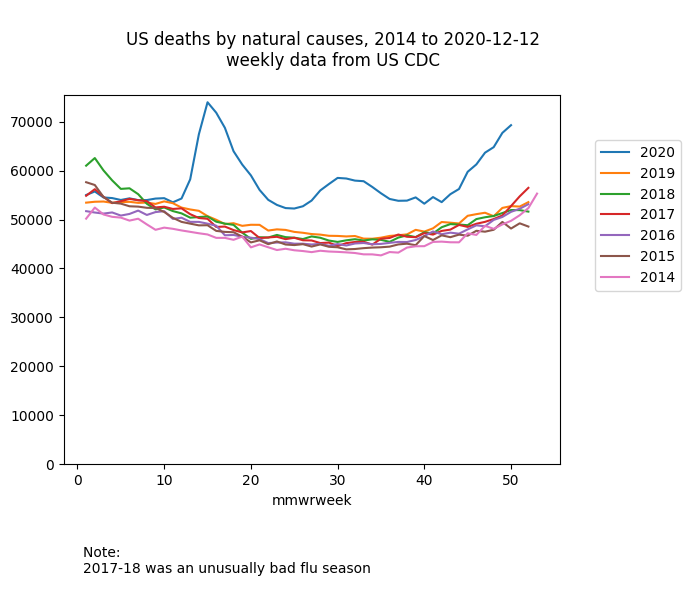

In [17]:
# scrub and plot the data
nat_cod_by_yr, last_year, last_mmwrweek_kept, n_most_recent_points_removed = scrub_df(nat_cod_by_yr, max_undercount)

latest_week_ending_date_displayed = year_and_week_to_week_ending_date[(last_year, last_mmwrweek_kept)]
end_date = latest_mmwryear if latest_mmwryear_is_complete else latest_week_ending_date_displayed
notes = '\n'.join([
    #f'Ignoring the most recent {n_most_recent_points_removed} data points to avoid an undercount of more than {100 * max_undercount}%.',
    '2017-18 was an unusually bad flu season',
])

plot_df(
    nat_cod_by_yr,
    f'''
        US deaths by natural causes, 2014 to {end_date}
        weekly data from US CDC
    ''',
    caption=(f'''
        Note:
        {notes}
    '''),
    order=reversed, 
    xylegend=(1.1,0.8)
)

So we see much higher weekly deaths from natural causes since week 12.  How many more people are dying than we would expect?
"Excess deaths" may be defined in several ways.
One is to note the generally upward march of the 2014-2019 curves and extrapolate an expected curve for 2020.  This was done in an upcoming notebook, with mixed results.  
But here we simply subtract the deaths in 2019 from those in 2020, which likely gets us close to more sophisticated approaches, with the advantage of simplicity.  Note that 2020 deaths tracked 2019 deaths very closely in the pre-covid period, so this shortcut seems ok.

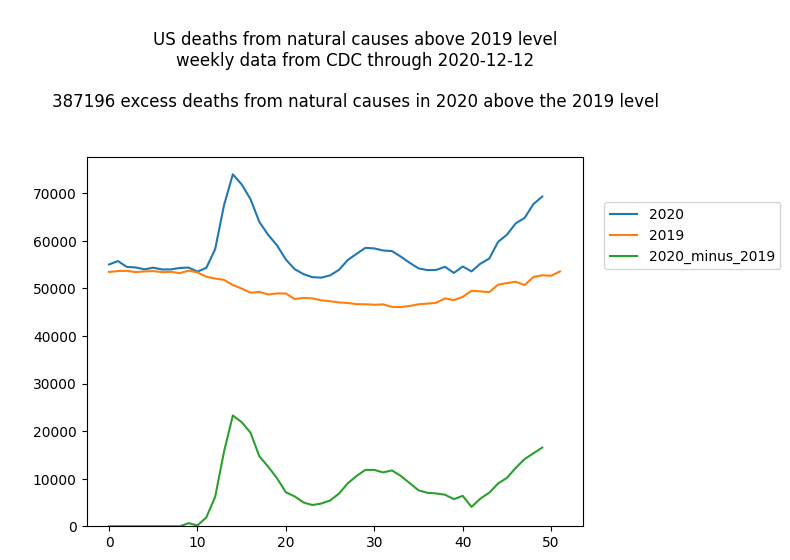

In [18]:
def bracket_pandemic(df, col, final_incomplete_year=None):

    # apply a floor of zero to avoid negative excess deaths
    def floor_zero(x):
        return x if x > 0 else 0
    df[col] = df[col].apply(floor_zero)

    # assume negligible covid deaths in the first weeks of 2020
    last_pre_pandemic_mmwrweek = 9
    df[col].iloc[:last_pre_pandemic_mmwrweek] = 0
    
    # remove future weeks of incomplete year
    if final_incomplete_year:
        df.loc[np.isnan(df[final_incomplete_year]), col] = None
    
    return df

excess_nat_cod = pd.DataFrame({
    2019: nat_cod_by_yr[2019].values,
    2020: nat_cod_by_yr[2020].values,
    '2020_minus_2019': (nat_cod_by_yr[2020] - nat_cod_by_yr[2019]).values,
})
excess_nat_cod = bracket_pandemic(excess_nat_cod, '2020_minus_2019', 2020)
plot_df(
    excess_nat_cod[[2020, 2019, '2020_minus_2019']],
    title=f'''
        US deaths from natural causes above 2019 level
        weekly data from CDC through {end_date}
        
        {int(excess_nat_cod['2020_minus_2019'].sum())} excess deaths from natural causes in 2020 above the 2019 level
        
    ''',
    xylegend=(1.22, 0.8),
)

In [36]:
# compute new trim array for unnatural causes.
glance_at_unnatural_causes = 0
if glance_at_unnatural_causes:
    # deaths from all causes are swamped by deaths from natural causes, so let's look at unnatural causes.
    # how does that sum compare with the CDC's estimate?
    # the CDC used deaths from all causes, and fancier baseline than simply 2019.
    # But using all_causes in 2020 minus 2019:
    all_cod_by_yr, *_ = scrub_df(select_col(loc_data_raw, 'all_cause'), .05)
    all_cod_by_yr['2020_minus_2019'] = all_cod_by_yr[2020] - all_cod_by_yr[2019]
    total_excess_deaths = int(all_cod_by_yr['2020_minus_2019'].sum())
    # todo replace "so far in 2020"
    plot_df(
        all_cod_by_yr[[2020, 2019, '2020_minus_2019']],
        f'''
            US deaths by all causes, 2019 to 2020
            weekly data from US CDC

            {total_excess_deaths} excess deaths from all causes so far in 2020 above the 2019 level
        ''',
        caption=f'''
            Note:
            Ignoring the most recent {n_most_recent_points_removed} data points
            to avoid an undercount of more than {int(100 * max_undercount)}%.
        ''',
        xylegend=(1.22, 0.8)
    )

    # deaths from unnatural causes [suicide, overdose, car accidents, etc]
    # are not categorized in this dataset 
    # but seem to be reported with yet greater delay.
    unnat_cod_by_yr = all_cod_by_yr - nat_cod_by_yr
    plot_df(unnat_cod_by_yr)

How many of these excess deaths were officially attributed to covid?

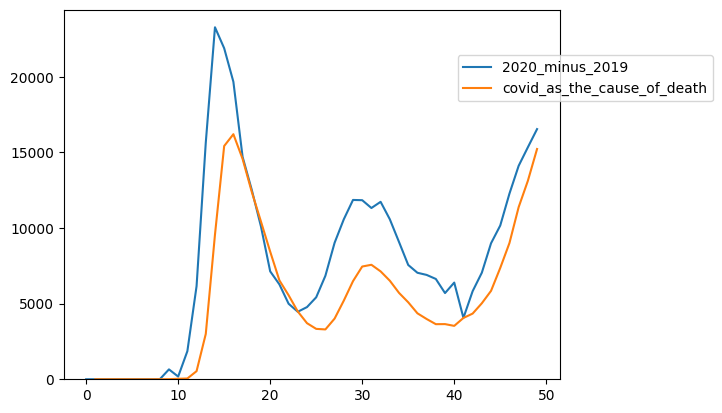

In [20]:
# The CDC MMWR data include deaths of covid as _the_ underlying cause
# and as _one_ contributing cause.

data_us = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
data_us_2020 = data_us.query(f"mmwryear == 2020")
covid = pd.DataFrame(
    {
        'covid_as_one_cause_of_death': data_us_2020['covid_19_u071_multiple_cause_of_death'].values,
        'covid_as_the_cause_of_death': data_us_2020['covid_19_u071_underlying_cause_of_death'].values,
    },
    index=data_us_2020.mmwrweek
)
trim_df(covid, max_undercount)
x = pd.DataFrame({
    '2020_minus_2019': excess_nat_cod['2020_minus_2019'],
    #'covid_as_one_cause_of_death': covid['covid_as_one_cause_of_death'],
        # assuming one_cause includes the_cause since it is always slightly higher.
    'covid_as_the_cause_of_death': covid['covid_as_the_cause_of_death'],
})
plot_df(x)

Covid deaths correlate pretty well with excess deaths, but don't peak as high until the most recent peak-in-the-making, in which covid deaths track total excess deaths very closely.

To check sanity, let's sum all the individual natural causes of death and compare it with the total that we've been using:

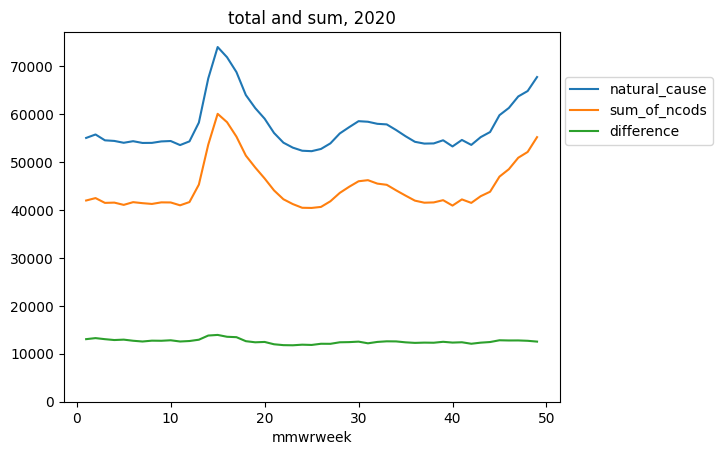

In [21]:
spacetime_columns = ['jurisdiction_of_occurrence', 'mmwryear', 'mmwrweek', 'week_ending_date']
aggregate_columns = ['all_cause', 'natural_cause', 'covid_19_u071_multiple_cause_of_death']
flag_columns = list(col for col in loc_data_raw.columns if col.startswith('flag'))
nondisease_columns = spacetime_columns + aggregate_columns + flag_columns
causes_of_death = list(col for col in loc_data_raw.columns if col not in nondisease_columns)
#print(len(causes_of_death))
#print(causes_of_death)
def sanity(yr):
    df = loc_data_raw.query(f'mmwryear == {yr}')
    #display(df)
    sanity = pd.DataFrame(
        dict(
            natural_cause=df['natural_cause'].values,
            sum_of_ncods=df[causes_of_death].sum(axis=1).values,
            difference=(df['natural_cause'] - df[causes_of_death].sum(axis=1)).values,
            #covid_as_the_cause_of_death=covid['covid_as_the_cause_of_death'],
        ),
        index=df.mmwrweek
    )
    trim_df(sanity, max_undercount)
    plot_df(sanity, title=f'total and sum, {yr}')  #, xylegend=(1.35,.8))
    
sanity(2020)

So the causes of death included in the MMWR are just the major ones--they add up to about 75% of the total deaths from natural causes.  However, the difference is fairly constant, so we can see most of the interesting variation in the individual causes of death in the dataset:

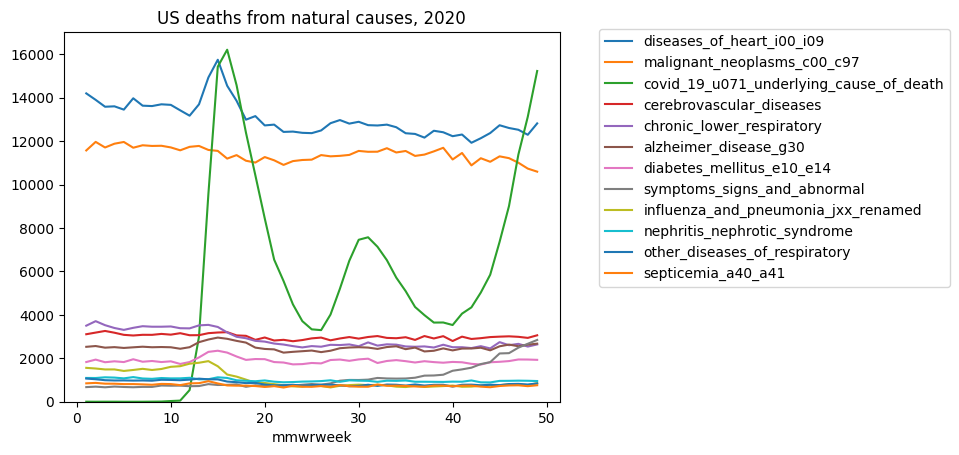

In [22]:
def cods(yr):
    df = loc_data_raw.query(f'mmwryear == {yr}')
    cods = pd.DataFrame(
        {
            key: df[key].values
            for key in causes_of_death
        },
        index=df.mmwrweek
    )
    trim_df(cods, max_undercount)
    plot_df(cods, title=f'US deaths from natural causes, 2020', xylegend=(1.52, 0.9), order='by_sum')
    
cods(2020)

Note:
- the jump in heart disease deaths during the first covid peak (and smaller rises in some other causes of death).
- <a id="abnormal_rise"></a>the gradual rise in "symptoms_signs_and_abnormal" starting at week 30 (adding to [dangling threads](#dangling-threads)).

Presumably there is not usually a springtime peak in heart attacks, but let's check:

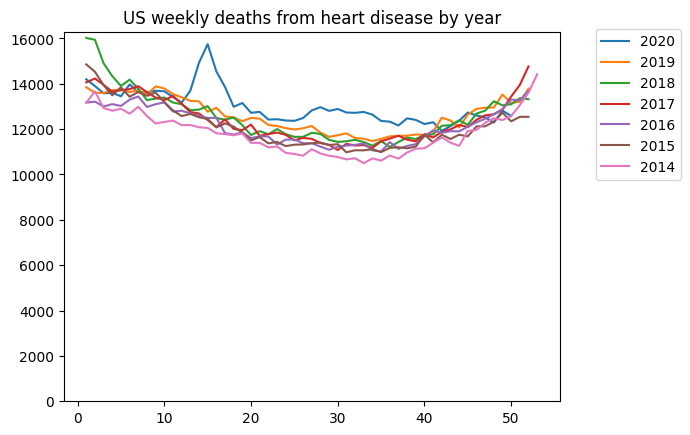

In [23]:
def align53(listt):
    n = len(listt)
    if n < 53:
        listt = np.append(listt, [None] * (53 - n))
    return listt

def plot_cod_thru_yrs(cod, title):
    df = loc_data_raw[['mmwryear', 'mmwrweek', cod]]
    cods = pd.DataFrame(
        {
            yr: align53(df.query(f'mmwryear == {yr}')[cod].values)
            for yr in df.mmwryear.unique()
            if yr <= latest_mmwryear
        },
        index=sorted(df.query(f'mmwryear == 2014').mmwrweek)  # or range(1, 53 + 1)
    )
    #display(cods)
    cods, *_ = trim_df_by_year(cods, max_undercount)
    #print(*_)
    #display(cods)
    plot_df(cods, title=title, order=reversed, xylegend=(1.1, 0.9))
    
plot_cod_thru_yrs('diseases_of_heart_i00_i09', 'US weekly deaths from heart disease by year')

Indeed, the springtime heart attack peak is unique to 2020.  This peak, and the subsequent excess heart deaths in weeks 25-35, could reflect deaths that should have been attributed to covid, or deaths of people who pre-pandemic would have gone to the hospital and survived but avoided the hospital due to fear of covid.  It will take time for the CDC to tease apart the direct vs indirect deaths due to covid: "it is unclear to what extent these represent misclassified COVID-19 deaths or deaths indirectly related to the pandemic (e.g., because of disruptions in health care access or utilization)" [Excess Deaths Associated with COVID-19, by Age and Race and Ethnicity — United States, January 26–October 3, 2020](https://www.cdc.gov/mmwr/volumes/69/wr/mm6942e2.htm?s_cid=mm6942e2_w)


# dangling threads

- the gradual rise in "symptoms_signs_and_abnormal" ([icd10 page](https://icd-codes.com/icd10cm/R00-R99)) in 2020 starting at week 30 (see [here](#abnormal_rise)).
- (apparently fixed in a later dataset version: 2014 stands out as an unusual year for heart disease deaths)

# next steps

- add dates to mmwr weeks somehow (dates for each mmwr week vary between years)
- explore excess deaths by state/region
- derive undercount_from_latest (a result used above), and correct for it
- compute spatial heat map over time
- want to help?  have a comment?  email me at john@saponara.us 
  or pursue any dangling thread, next step, or code "todo" and please let me know.